# Import thư viện

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import cv2
from skimage.feature import hog
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import LSTM, Dense, Dropout, Input, Concatenate, BatchNormalization, RepeatVector, GlobalAveragePooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Trích xuất đặc trưng từ ảnh

In [6]:
def extract_hog_from_image(img_path, target_size=(320, 320)):
    # Đọc ảnh dưới dạng grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Không thể đọc ảnh từ đường dẫn: {img_path}")

    # Thay đổi kích thước ảnh
    img = cv2.resize(img, target_size)

    # Tạo mask nhị phân từ ảnh (giá trị ngưỡng 127)
    _, mask = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    # Trích xuất đặc trưng HOG
    features, _ = hog(mask, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True)
    return features

In [7]:
def process_image_folder(folder_path, target_size=(320, 320)):
    features_list = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            hog_features = extract_hog_from_image(img_path, target_size)
            features_list.append(hog_features)

    return features_list

In [8]:
# Đưa vector đặc trưng về giá trị
def reduce_features_to_scalar(features_list):
    features_array = np.array(features_list)

    # Tính L2 norm (độ dài vector)
    f_t = np.linalg.norm(features_array, axis=1)

    return f_t

In [9]:
def create_feature_dataframe(image_folder, features, col_time='filename', col_feature='f_t'):
    file_names = sorted(os.listdir(image_folder))

    # Chuyển features thành danh sách hai chiều nếu cần
    if isinstance(features, np.ndarray):
        if features.ndim == 1:
            features = features.reshape(-1, 1)  # Chuyển thành mảng 2D nếu là 1D
        features = features.tolist()
    elif isinstance(features, list):
        if all(isinstance(row, (int, float, np.float64, np.int64)) for row in features):
            features = [[row] for row in features]  # Chuyển thành danh sách 2D nếu là danh sách 1D
    else:
        raise TypeError("features phải là list hoặc numpy.ndarray")

    assert len(file_names) == len(features), "Số file ảnh không khớp với số dòng trong features"

    # Tạo DataFrame
    df = pd.DataFrame(features, columns=[col_feature])
    df.insert(0, col_time, file_names)

    return df

# Đọc và xử lý dữ liệu số

In [10]:
def read_data_number(data_path, time_col="thoi_gian"):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(data_path)

    # Chuyển đổi cột thời gian sang kiểu datetime và đặt làm index
    data[time_col] = pd.to_datetime(data[time_col])
    data.set_index(time_col, inplace=True)

    # Tái lấy mẫu và tính toán thống kê
    y_t = data[['Mực nước hồ (m)', 'Lưu lượng đến hồ (m³/s)']].resample("D").mean()

    return y_t

In [11]:
def create_dataframe(y_t, time_col="thoi_gian", value_col_1="y_t_1", value_col_2="y_t_2"):
    df = pd.DataFrame({time_col: y_t.index,
                       value_col_1: y_t['Mực nước hồ (m)'].values,
                       value_col_2: y_t['Lưu lượng đến hồ (m³/s)'].values})
    return df

# Kết hợp đặc trưng dữ liệu

### Chuẩn hóa đặc trưng ảnh về khoảng dữ liệu số gốc

In [12]:
def rescale_features(df, col="f_t", new_min=0, new_max=1):
    # Tạo một bản sao của DataFrame để không thay đổi dữ liệu gốc
    df_rescaled = df.copy()

    # Lấy dữ liệu của cột cần chuẩn hóa
    col_data = df[col]
    old_min = col_data.min()
    old_max = col_data.max()

    # Kiểm tra tránh chia cho 0 nếu tất cả giá trị giống nhau
    if old_min == old_max:
        df_rescaled[col] = new_min
    else:
        df_rescaled[col] = new_min + (col_data - old_min) * (new_max - new_min) / (old_max - old_min)

    return df_rescaled

### Xác định điểm bất thường

In [13]:
def adjust_y_t(y_t, f_t, alpha):
    mean_y = y_t.mean()
    std_y = y_t.std()

    # Khoảng tin cậy 99,9% dựa trên trung bình và sai số chuẩn
    a = mean_y - alpha * (std_y / np.sqrt(len(y_t)))
    b = mean_y + alpha * (std_y / np.sqrt(len(y_t)))

    # Áp dụng điều chỉnh dựa trên điều kiện
    adjusted_y = np.where(
        (y_t >= a) & (y_t <= b), mean_y, np.where(y_t > b, ((y_t * f_t + mean_y) / (f_t)), ((y_t * f_t) / (1 + f_t)) )
    )

    return pd.Series(adjusted_y, index=y_t.index)

### Tính biến ngoại sinh X_t

In [14]:
def cal_exogenous_variable(y_t, f_t, alpha, time_col="thoi_gian", y_value_col="y_t_1", filename_col="filename", f_t_col="f_t",
                             year_month_col="year_month", f_t_value_col="f_t_value", X_t_col="X_t"):
    # Kiểm tra các cột cần thiết
    required_y_t_cols = {time_col, y_value_col}
    required_f_t_cols = {filename_col, f_t_col}
    if not required_y_t_cols.issubset(y_t.columns):
        raise ValueError(f"DataFrame y_t cần chứa các cột: {required_y_t_cols}")
    if not required_f_t_cols.issubset(f_t.columns):
        raise ValueError(f"DataFrame f_t cần chứa các cột: {required_f_t_cols}")

    # Đảm bảo không thay đổi dữ liệu gốc
    y_t = y_t.copy()
    f_t = f_t.copy()

    # Chuyển đổi cột thời gian sang kiểu datetime và tạo cột year_month
    y_t[time_col] = pd.to_datetime(y_t[time_col])
    y_t[year_month_col] = y_t[time_col].dt.strftime("%Y-%m")

    # Chuẩn hóa tên file trong f_t và tạo cột year_month
    f_t[year_month_col] = (
        f_t[filename_col]
        .str.replace(".jpg", "", regex=True)
        .str.replace("_", "-", regex=False)
    )

    # Tạo từ điển ánh xạ: year_month -> f_t
    mapping = f_t.set_index(year_month_col)[f_t_col].to_dict()

    # Ánh xạ giá trị f_t tương ứng vào y_t; nếu không có giá trị tương ứng, gán mặc định 1.0
    y_t[f_t_value_col] = y_t[year_month_col].map(mapping).fillna(1.0)

    # Điều chỉnh y_t thành X_t sử dụng hàm adjust_y_t (hàm này cần được định nghĩa)
    y_t[X_t_col] = adjust_y_t(y_t[y_value_col], y_t[f_t_value_col], alpha)
    # y_t[X_t_col] = general_transition(y_t[y_value_col], y_t[f_t_value_col], alpha, delta=0.5)

    return y_t[[time_col, X_t_col]]

In [15]:
def plot_with_confidence_interval(X_t, y_t, time_col="thoi_gian", x_col="X_t", y_col="y_t_1", alpha=3.291):
    # Tính trung bình và độ lệch chuẩn của y_t
    mean_yt = y_t[y_col].mean()
    std_yt = y_t[y_col].std()

    # Tính khoảng tin cậy 99.9%
    ci_lower = mean_yt - alpha * (std_yt / np.sqrt(len(y_t)))
    ci_upper = mean_yt + alpha * (std_yt / np.sqrt(len(y_t)))

    # Tạo figure với kích thước đã cho
    plt.figure(figsize=(10, 6))

    # Vẽ giá trị X_t dưới dạng scatter
    plt.scatter(X_t[time_col], X_t[x_col], color='blue', label=x_col, s=20)

    # Vẽ giá trị y_t dưới dạng đường line
    plt.plot(X_t[time_col], y_t[y_col], color='red', label=y_col, linewidth=2)

    # Vẽ vùng khoảng tin cậy 99.9%
    plt.fill_between(X_t[time_col], ci_lower, ci_upper,
                     color='gray', alpha=0.3, label='99.9% CI')

    # Cấu hình biểu đồ
    plt.title(f"Biểu đồ của {x_col} và {y_col} theo thời gian với khoảng tin cậy 99.9%")
    plt.xlabel("Thời gian")
    plt.ylabel("Giá trị")
    plt.legend(loc='upper left')
    plt.grid(True)

    # Hiển thị biểu đồ
    plt.show()

# Áp dụng LSTM để dự đoán

### Tiền xử lý dữ liệu

In [16]:
def create_dataset(X, y, n_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - n_steps):
        Xs.append(X[i:i+n_steps])
        ys.append(y[i+n_steps])
    return np.array(Xs), np.array(ys)

In [17]:
# Chuẩn hóa dữ liệu
def scaler(df, time_steps):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X = df[['X_t', 'y_t_1', 'y_t_2']]
    y = df[['y_t_1']]

    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y)

    # Tạo nhãn cho dữ liệu
    X_data, y_data = create_dataset(X, y, time_steps)

    return scaler_X, scaler_y, X_data, y_data

In [18]:
# Khôi phục dữ liệu sau chuẩn hóa
def inverse_transform_data(scaler, y_pred, y_test):
    y_pred_predict = scaler.inverse_transform(y_pred)
    y_pred_predict = pd.DataFrame(y_pred_predict)

    y_test = scaler.inverse_transform(y_test)
    y_test = pd.DataFrame(y_test)

    return y_pred_predict, y_test

### Chia dữ liệu

In [19]:
# Chuẩn hóa dữ liệu
def split_data(X_data, y_data, time_steps):
    # Chia dữ liệu thành tập huấn luyện, kiểm tra và test
    train_length = int(len(X_data) * 0.7)
    val_length = int((len(X_data) - train_length) / 2)

    X_train, y_train = X_data[:train_length], y_data[:train_length]
    X_val, y_val = X_data[train_length:train_length+val_length], y_data[train_length:train_length+val_length]
    X_test, y_test = X_data[-val_length:], y_data[-val_length:]

    # Reshape dữ liệu đầu vào
    X_train = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[2])
    X_val = X_val.reshape(X_val.shape[0], time_steps, X_val.shape[2])
    X_test = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[2])

    print("Kích thước X_train:", X_train.shape)
    print("Kích thước X_val:", X_val.shape)
    print("Kích thước X_test:", X_test.shape)
    print("Kích thước y_train:", y_train.shape)
    print("Kích thước y_val:", y_val.shape)
    print("Kích thước y_test:", y_test.shape)

    return X_train, y_train, X_val, y_val, X_test, y_test

### Xây dựng mô hình LSTM

In [20]:
def build_forecast_model(time_steps, features, lstm_units=[64, 32], dropout_rate=0.3):
    inp = Input(shape=(time_steps, features))

    # Bi-directional Encoder
    x = LSTM(lstm_units[0], return_sequences=True, activation='tanh')(inp)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = LSTM(lstm_units[1], return_sequences=True, activation='tanh')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Pooling để gom thông tin cả chuỗi
    x = GlobalAveragePooling1D()(x)

    # Dense layers
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Output scalar
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inp, outputs=out)
    return model

def train_model(X_train, y_train, X_val, y_val,epochs=100, batch_size=32, save_best_model='best_model.h5', initial_lr=1e-3):
    time_steps, features = X_train.shape[1], X_train.shape[2]
    model = build_forecast_model(time_steps, features)

    # Compile với optimizer và loss phù hợp cho hồi quy
    optimizer = Adam(learning_rate=initial_lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Callbacks: lưu model tốt nhất, dừng sớm, giảm lr khi plateau
    checkpoint = ModelCheckpoint(save_best_model, monitor='val_loss',save_best_only=True, mode='min', verbose=1)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[checkpoint],
                        verbose=2)

    return model, history

### Đánh giá mô hình

In [21]:
# Xác định điểm bất thường
def evaluate_outside_confidence(y_test, y_true, alpha=3.291):
    # Tính trung bình và độ lệch chuẩn của y_test
    mean_yt = np.mean(y_test)
    std_yt = np.std(y_test, ddof=1)  # ddof=1 để tính std của mẫu

    # Tính khoảng tin cậy 99.9%
    ci_lower = mean_yt - alpha * (std_yt / np.sqrt(len(y_test)))
    ci_upper = mean_yt + alpha * (std_yt / np.sqrt(len(y_test)))

    # Xác định các index mà y_test nằm ngoài khoảng tin cậy
    outside_ci_indices = np.where((y_test < ci_lower) | (y_test > ci_upper))[0]

    # Truy xuất dữ liệu đúng cách
    y_t_outside = y_test.iloc[outside_ci_indices]
    y_true_outside = y_true.iloc[outside_ci_indices]

    return y_t_outside, y_true_outside

In [22]:
def evaluate_metrics(y_true, y_pred):
    # Chuyển về numpy array 1D để mọi phép tính sum đều cho ra scalar
    y_true_arr = np.ravel(y_true)
    y_pred_arr = np.ravel(y_pred)

    mae = round(mean_absolute_error(y_true_arr, y_pred_arr), 6)
    mse = round(mean_squared_error(y_true_arr, y_pred_arr), 6)
    rmse = round(np.sqrt(mse), 6)

    # Tính sai số dự báo
    errors = y_true_arr - y_pred_arr

    # Tracking Signal: TS = Tổng sai số dự báo tích lũy / Tổng độ lệch tuyệt đối của sai số
    tracking_signal = np.sum(errors) / np.sum(np.abs(errors))
    tracking_signal = round(tracking_signal, 6)

    # NSE (Nash–Sutcliffe Efficiency):
    # NSE = 1 - [ sum((y_true - y_pred)^2) / sum((y_true - mean(y_true))^2 ) ]
    numerator   = np.sum((y_true_arr - y_pred_arr) ** 2)
    denominator = np.sum((y_true_arr - np.mean(y_true_arr)) ** 2)

    # Sau khi ravel, denominator là float; chỉ cần so sánh bình thường
    if denominator == 0:
        nse = np.nan
    else:
        nse = 1 - numerator / denominator
        nse = round(nse, 6)

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "Tracking Signal": tracking_signal,
        "NSE": nse
    }

### Dự báo và trực quan

In [23]:
# Trực quan hóa dữ liệu dự báo không dùng index
def plot_forecast(y_true, y_pred, title="Lake level forecast", alpha=3.291):
    # Tính trung bình và độ lệch chuẩn của y_true
    mean_yt = np.mean(y_true)
    std_yt = np.std(y_true, ddof=1)

    # Tính khoảng tin cậy 99.9%
    ci_lower = mean_yt - alpha * (std_yt / np.sqrt(len(y_true)))
    ci_upper = mean_yt + alpha * (std_yt / np.sqrt(len(y_true)))

    # Tạo trục x là các chỉ mục tuần tự
    x = np.arange(len(y_true))

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 5))

    # Vẽ dữ liệu thực tế
    plt.plot(x, y_true, label="Actual value", color="blue", linestyle='-', alpha=0.7)

    # Vẽ dự báo
    plt.plot(x, y_pred, label="Predicted value", color="red", linestyle='--', alpha=0.7)

    # Vẽ vùng khoảng tin cậy 99.9%
    plt.fill_between(x, ci_lower, ci_upper, color='gray', alpha=0.3, label='99.9% CI')

    # Thiết lập tiêu đề và nhãn
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Water Level (m)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.5)

    # Hiển thị biểu đồ
    plt.show()

# Thực hiện từng phần

### Tiền xử lý dữ liệu ảnh

In [24]:
# Đọc dữ liệu ảnh và trích xuất HOG
folder_img = r"/content/drive/MyDrive/CoChau/EAI-2024/DataSetAnKhe/images_AnKhe"
features = process_image_folder(folder_img)

# Đưa vector đặc trưng về giá trị
f_t_features = reduce_features_to_scalar(features)
f_t = create_feature_dataframe(folder_img, f_t_features, col_time='filename', col_feature='f_t')

### Tiền xử lý dữ liệu số

In [25]:
# Đọc dữ liệu đầu vào
path_data = r"/content/drive/MyDrive/CoChau/EAI-2024/DataSetAnKhe/data_so_AnKhe/AnKhe.csv"
data = read_data_number(path_data, time_col="thoi_gian")

# Tạo DataFrame chứa thời gian và mực nước
y_t = create_dataframe(data, time_col="thoi_gian", value_col_1="y_t_1", value_col_2="y_t_2")

### Chuẩn hóa khoảng và kết hợp đặc trưng

In [26]:
# Chuẩn hóa đặc trưng ảnh về khoảng dữ liệu mực nước gốc
f_t = rescale_features(f_t, col="f_t", new_min=y_t['y_t_1'].min(), new_max=y_t['y_t_1'].max())

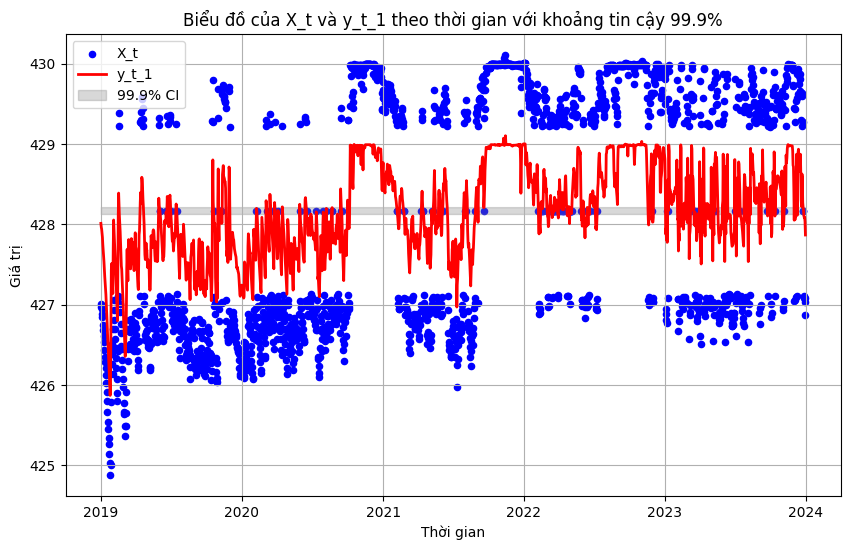

In [27]:
# Tính X_t
alpha = 3.291 # 99.9%
X_t = cal_exogenous_variable(y_t, f_t, alpha)

# Trực quan X_t
plot_with_confidence_interval(X_t, y_t, time_col="thoi_gian", x_col="X_t", y_col="y_t_1", alpha=alpha)

### Chia dữ liệu

In [28]:
# Chuyển 'thoi_gian' về datetime để đảm bảo kiểu dữ liệu đúng
X_t["thoi_gian"] = pd.to_datetime(X_t["thoi_gian"])
y_t["thoi_gian"] = pd.to_datetime(y_t["thoi_gian"])

# Gộp hai DataFrame theo 'thoi_gian'
df_ts = pd.merge(y_t[["thoi_gian", "y_t_1", "y_t_2"]], X_t[["thoi_gian", "X_t"]], on="thoi_gian", how="inner")
df_ts.set_index("thoi_gian", inplace=True)

In [29]:
time_steps = 7

scaler_X, scaler_y, X_data, y_data = scaler(df_ts, time_steps)
# X_data, y_data = scaler_v1(df_ts, time_steps)

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X_data, y_data, time_steps)

Kích thước X_train: (1273, 7, 3)
Kích thước X_val: (273, 7, 3)
Kích thước X_test: (273, 7, 3)
Kích thước y_train: (1273, 1)
Kích thước y_val: (273, 1)
Kích thước y_test: (273, 1)


### Huấn luyện ARIMA

In [31]:
model, history = train_model(X_train, y_train,
                             X_val, y_val,
                             epochs=200,
                             batch_size=16,
                             save_best_model='/content/drive/MyDrive/CoChau/EAI-2024/Results/best_model_Fusion_HOG_LSTM.keras',
                             initial_lr=1e-3)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.06373, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/best_model_Fusion_HOG_LSTM.keras
80/80 - 8s - 99ms/step - loss: 0.0688 - val_loss: 0.0637
Epoch 2/200

Epoch 2: val_loss improved from 0.06373 to 0.04553, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/best_model_Fusion_HOG_LSTM.keras
80/80 - 2s - 29ms/step - loss: 0.0412 - val_loss: 0.0455
Epoch 3/200

Epoch 3: val_loss did not improve from 0.04553
80/80 - 1s - 16ms/step - loss: 0.0314 - val_loss: 0.0483
Epoch 4/200

Epoch 4: val_loss improved from 0.04553 to 0.04032, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/best_model_Fusion_HOG_LSTM.keras
80/80 - 1s - 18ms/step - loss: 0.0259 - val_loss: 0.0403
Epoch 5/200

Epoch 5: val_loss improved from 0.04032 to 0.02756, saving model to /content/drive/MyDrive/CoChau/EAI-2024/Results/best_model_Fusion_HOG_LSTM.keras
80/80 - 1s - 17ms/step - loss: 0.0216 - val_loss: 0.0276
Epoch 6/200

Ep

### Đánh giá mô hình dự báo trên tập test

In [32]:
# Đọc model tốt nhất
from keras.models import load_model
model = load_model('/content/drive/MyDrive/CoChau/EAI-2024/Results/best_model_Fusion_HOG_LSTM.keras')

# Dự đoán trên tập validation
y_pred = model.predict(X_test)

y_pred, y_test = inverse_transform_data(scaler_y, y_pred, y_test)

evaluate_metrics(y_test, y_pred)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


{'MAE': 0.209711,
 'MSE': 0.086482,
 'RMSE': np.float64(0.294078),
 'Tracking Signal': np.float64(-0.151908),
 'NSE': np.float64(0.328886)}

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


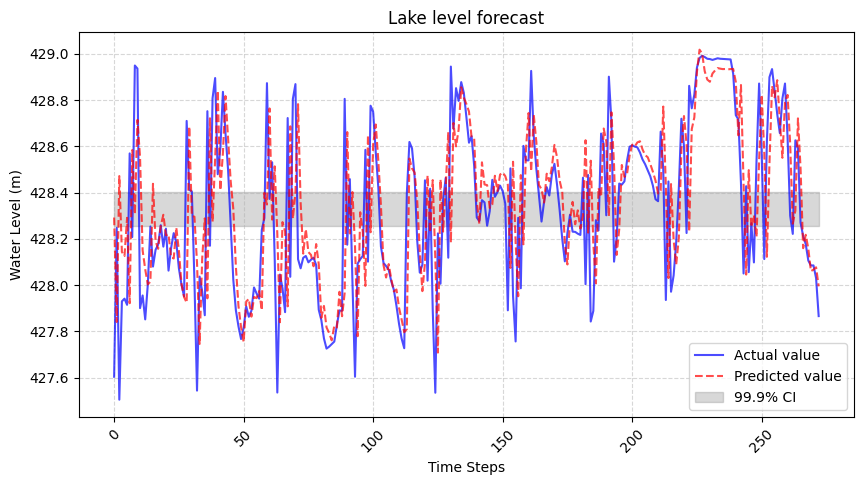

In [33]:
plot_forecast(y_test, y_pred)

In [34]:
y_t_out, y_true_out = evaluate_outside_confidence(y_test, y_pred)

# Đánh giá
evaluate_metrics(y_true_out, y_t_out)

{'MAE': 0.216482,
 'MSE': 0.091211,
 'RMSE': np.float64(0.302012),
 'Tracking Signal': np.float64(0.143961),
 'NSE': np.float64(0.098217)}